In [2]:
""" import useful functions """

import os

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate

# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate
import matplotlib.patches as mpatches
import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from multiprocessing import Pool
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# f(R) emu (eMANTIS)
from emantis import FofrBoost

In [3]:
col = sns.color_palette("colorblind") 

In [4]:
from LikelihoodFuncts_PCADR_muSigma import *

Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# Define cosmology
cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)


fR_universe = 0.0
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,0,0,0]

In [5]:
#### Run to get the data and covariance (with scale cuts) to put into the likelihood function
command = 'python Get_Data_3x2pt_fsigma8_GR.py --OmgC {} --OmgB {} --h {} --ns {} --As {}'.format(cosmo_universe["Omega_c"],cosmo_universe["Omega_b"],cosmo_universe["h"], cosmo_universe["n_s"],cosmo_universe["A_s"])
os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data
starting code
collecting data
starting linear scale cuts
ind_min= 298
ind_min= 310
ind_min= 297
ind_min= 321
ind_min= 308
ind_min= 332
ind_min= 296
ind_min= 233
ind_min= 342
ind_min= 317
ind_min= 220
ind_min= 257
ind_min= 231
ind_min= 207
ind_min= 301
ind_min= 218
ind_min= 322
ind_min= 289
ind_min= 241
ind_min= 252
ind_min= 206
ind_min= 263
ind_min= 227
ind_min= 216
ind_min= 303
ind_min= 325
ind_min= 237
ind_min= 205
ind_min= 246
ind_min= 257
ind_min= 224
ind_min= 287
ind_min= 214
ind_min= 276
ind_min= 267
ind_min= 204
ind_min= 303
ind_min= 232
ind_min= 194
ind_min= 181
ind_min= 250
ind_min= 239
ind_min= 210
ind_min= 218
ind_min= 258
ind_min= 192
ind_min= 180
ind_min= 199
ind_min= 302
ind_min= 224
ind_min= 155
ind_min= 279
ind_min= 167
ind_min= 142
ind_min= 153
ind_min= 186
ind_min= 175
ind_min= 164
ind_min= 141
ind_min= 245
ind_min= 116
ind_min= 103
ind_min= 259
ind_min= 277
ind_min= 149
ind_min= 127
ind_min= 158
ind_min= 137
ind_min= 90
ind_min= 113
ind

0

In [6]:
### Load and collect the data for likelihood
#npzfile = np.load("../Biases_parametrization/Data_storage_fR.npz")
npzfile = np.load("Data_storage_GR.npz")

C_ell_data_mock = [npzfile['C_ell_data'],npzfile['ell_data'],npzfile['z'],npzfile['Binned_distribution_source'],\
                    npzfile['Binned_distribution_lens'],20,1478.5,13]

Data_fsigma8= [npzfile['z_eff_fsigma8'], npzfile['fsigma8_data'],np.matrix(npzfile['invcov_fsigma8'])]

L_choleski_inv = np.matrix(npzfile['L_ch_inv'])

gauss_invcov_rotated = np.matrix(npzfile['Inverse_cov'])

## Plot to check data/covariance

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~ Get Covariance - for now just using SRD one ~~~~~~~~~~~~~~~~~~~~~~~~

covfile = np.genfromtxt("Y1_3x2pt_clusterN_clusterWL_cov")

shear_SRD = np.zeros((705,705))
ell_test_SRD = np.zeros(705)

for i in range(0,covfile.shape[0]):
    shear_SRD[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,8]+covfile[i,9] # non-gauss
    shear_SRD[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,8]+covfile[i,9] # non-gauss
    if int(covfile[i,0]) == int(covfile[i,1]):
        ell_test_SRD[int(covfile[i,0])] = covfile[i,2]

del covfile
SRD_compare = shear_SRD[:540,:540].copy()

idx = 0

bins_SRD = int(len(SRD_compare)/(len(C_ell_data_mock[0])/13))
print(bins_SRD)
for j in range(int(len(C_ell_data_mock[0])/13)):
    for i in range(bins_SRD):
        if i >= 13:
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 0)
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 1)
            idx += 1

covariance_uncut = np.matrix(SRD_compare)


20


In [8]:
print(ell_test_SRD[:20])
print(bin_ell_kk(20,15000,20,np.array([1])))
print(bin_ell_kk(20,1478.5,13,np.array([1])))

[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]
[[   23.59970245    32.85939707    45.75227075    63.70385538
     88.69901151   123.50138929   171.95899817   239.42967137
    333.37346775   464.17751136   646.30446899   899.89165011
   1252.97753734  1744.60192946  2429.12247153  3382.22483998
   4709.29111325  6557.05159727  9129.80841814 12712.02468297]]
[[  23.59970561   32.85941027   45.75230138   63.70391509   88.6991184
   123.5015712   171.95929751  239.43015228  333.37422663  464.17869231
   646.30628639  899.89442158 1252.98173181]]


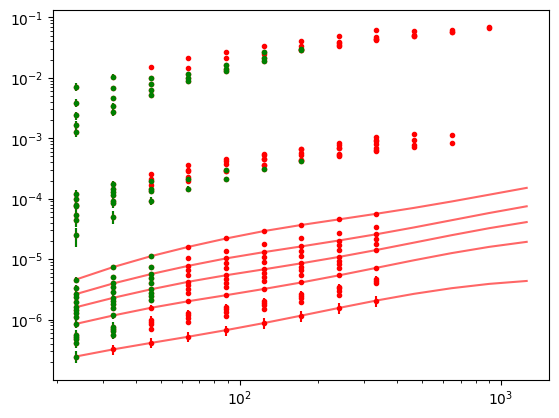

In [9]:
## Plot to check 3x2pt data
for i in range(len(C_ell_data_mock[1])):
    if np.any(L_choleski_inv[i] != 0):
        ell_i = C_ell_data_mock[1][i]
        plt.errorbar(ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi, yerr=ell_i*(ell_i+1)*np.sqrt(covariance_uncut[i,i])/2/np.pi, color="r", marker='.')

for i in range(len(C_ell_data_mock[1])):
    if np.any(gauss_invcov_rotated[i] != 0):
        ell_i = C_ell_data_mock[1][i]
        plt.errorbar(ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi, yerr=ell_i*(ell_i+1)*np.sqrt(covariance_uncut[i,i])/2/np.pi, color="g", marker='.')

for j in range(15):
    if j == 0 or j == 5 or j==9 or j==12 or j==14:
        ell_i = C_ell_data_mock[1][j*13:(j+1)*13]
        plt.plot(ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][j*13:(j+1)*13]/2/np.pi, "r", alpha=0.6)

plt.xscale("log")
plt.yscale("log")

(20,)


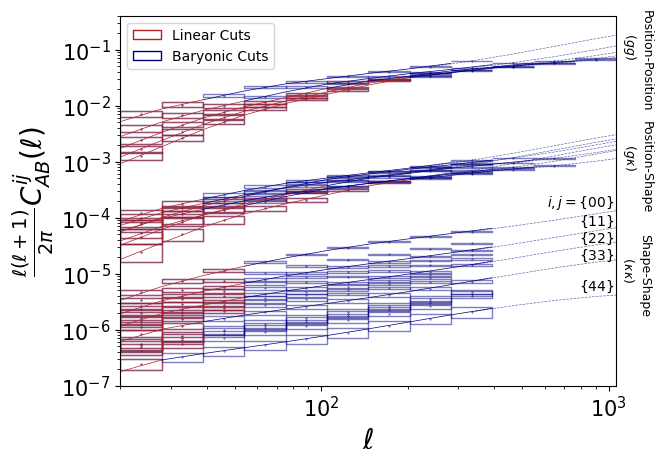

In [10]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

"""Check we match SRD"""
def bins_edges(ell_min, ell_max, ell_bin_num):

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    return 10**bin_edge1, 10**bin_edge2

# ell binning for shear
print(np.loadtxt("/home/c2042999/PCA_project/ell-values").shape)
ells_SRD_vals = np.loadtxt("/home/c2042999/PCA_project/ell-values")[:13]

min_ells = bins_edges(20, 1478.5, 13)[0]
max_ells = bins_edges(20, 1478.5, 13)[1]

def make_error_boxes(ax, xdata, ydata, x_lower, x_upper, yerror, color='k',
                     edgecolor='r', alpha=0.5):    
    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x_lower, ydata - yerror), x_upper-x_lower, 2*yerror)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor='none', alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to Axes
    ax.add_collection(pc)

    # Plot scatter
    artists = ax.scatter(xdata, ydata,color=color, marker="o" , s=0.1)

    return artists

# Create figure and Axes
fig, ax = plt.subplots(1)


for j in range(27):
    if j==0 or j ==5 or j==9 or j==12 or j==14 or j>=15:
        idx_new_1 = int(13*j+np.where(gauss_invcov_rotated[0,j*13:(j+1)*13]==0)[1][0])
        
        ell_i = min_ells[:idx_new_1%13+1]
        #print(int(np.floor(idx_new_1/13))*13)
        #print(C_ell_data_mock[0][0])
        #print(C_ell_data_mock[0][1])
        #fact_approx = - np.log10(C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13 + 1]*min_ells[1]*(min_ells[1]+1) -  C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13]*min_ells[0]*(min_ells[0]+1))/2
        #approx_avg_val_0 = 10**(np.log10(C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13]*C_ell_data_mock[1][0]*(C_ell_data_mock[1][0]+1)) )/2/np.pi
        approx_avg_val_0 = 10**(np.log10(C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13]*min_ells[0]*(min_ells[0]+1)) )/2/np.pi
        avg_val = np.append([approx_avg_val_0],ell_i[1:]*(ell_i[1:]+1)*0.5*(C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13:idx_new_1]/2/np.pi +  C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13 + 1:idx_new_1 + 1]/2/np.pi))

        #avg_val = ell_i*(ell_i+1)*0.5*(C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13 - 1:idx_new_1]/2/np.pi +  C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13:idx_new_1 + 1]/2/np.pi)

        #ell_i = max_ells[:idx_new_1%13]


        ax.plot(ell_i,avg_val, color="firebrick", alpha=1.0,linewidth=0.5)

for j in range(27):
    if j==0 or j ==5 or j==9 or j==12 or j==14 or j>=15:
        idx_new_1 = int(13*j+np.where(gauss_invcov_rotated[0,j*13:(j+1)*13]==0)[1][0])
        idx_new = int(13*j+np.where(L_choleski_inv[0,j*13:(j+1)*13]==0)[1][0])
        
        avg_val = 0.5*(C_ell_data_mock[0][idx_new_1-1:idx_new]/2/np.pi +  C_ell_data_mock[0][idx_new_1:idx_new + 1]/2/np.pi)
        ell_i = max_ells[idx_new_1%13 - 1:idx_new%13]
        ax.plot(ell_i,ell_i*(ell_i+1)*avg_val, color="navy", alpha=1.0,linewidth=0.5)

for j in range(27):
    if j==0 or j ==5 or j==9 or j==12 or j==14 or j>=15:
        idx_new = int(13*j+np.where(L_choleski_inv[0,j*13:(j+1)*13]==0)[1][0])
        ell_i = C_ell_data_mock[1][idx_new-1:(j+1)*13]
        ax.plot(ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][idx_new-1:(j+1)*13]/2/np.pi,color="navy",linestyle="--", alpha=0.6,linewidth=0.5)


for i in range(len(C_ell_data_mock[1])):
    if np.any(L_choleski_inv[i] != 0):
        ell_i = C_ell_data_mock[1][i]
        ell_i_minus = C_ell_data_mock[1][i-1]
        ell_i_plus = C_ell_data_mock[1][i+1]
        Cell_fact_i = ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi
        _ = make_error_boxes(ax, ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi, min_ells[i%13],max_ells[i%13],ell_i*(ell_i+1)*np.sqrt(covariance_uncut[i,i])/2/np.pi,edgecolor="navy",color="navy")


## Plot to check 3x2pt data
for i in range(len(C_ell_data_mock[1])):
    if np.any(gauss_invcov_rotated[i] != 0):
        ell_i = C_ell_data_mock[1][i]
        ell_i_minus = C_ell_data_mock[1][i-1]
        ell_i_plus = C_ell_data_mock[1][i+1]
        Cell_fact_i = ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi
        _ = make_error_boxes(ax, ell_i,ell_i*(ell_i+1)*C_ell_data_mock[0][i]/2/np.pi, min_ells[i%13],max_ells[i%13],ell_i*(ell_i+1)*np.sqrt(covariance_uncut[i,i])/2/np.pi,edgecolor="firebrick",color='firebrick')

"""
# adds crosses only at specific points
for j in range(15):
    if j==0 or j ==5 or j==9 or j==12 or j==14:
        idx_new = int(13*j+np.where(L_choleski_inv[0,j*13:(j+1)*13]==0)[1][0])
        idx_new_1 = int(13*j+np.where(gauss_invcov_rotated[0,j*13:(j+1)*13]==0)[1][0])

        ell_i = C_ell_data_mock[1][:idx_new_1%13]
        Cell_fact_i = ell_i*(ell_i+1)*C_ell_data_mock[0][int(np.floor(idx_new_1/13))*13:idx_new_1]/2/np.pi
        ax.scatter(ell_i, Cell_fact_i,color="firebrick", marker="x")
        
        ell_i = C_ell_data_mock[1][idx_new_1%13:idx_new%13 ]
        Cell_fact_i = ell_i*(ell_i+1)*C_ell_data_mock[0][idx_new_1:idx_new ]/2/np.pi
        ax.scatter(ell_i, Cell_fact_i,color="navy", marker="x")
"""

plt.text(1.1e3,1e-2, "Position-Position\n" + r"      ($gg$)", rotation=-90, fontsize=9)
plt.text(1.1e3,1.5e-4, "Position-Shape\n" + r"      ($g\kappa$)", rotation=-90, fontsize=9)
plt.text(1.1e3,2e-6, "Shape-Shape\n" + r"      ($\kappa\kappa$)", rotation=-90, fontsize=9)
plt.text(6.1e2,1.6e-4, r"$i,j=\{00\}$")
plt.text(7.9e2,7.3e-5, r"$\{11\}$")
plt.text(7.9e2,3.6e-5, r"$\{22\}$")
plt.text(7.9e2,1.8e-5, r"$\{33\}$")
plt.text(7.9e2,5e-6, r"$\{44\}$")

plt.xscale("log")
plt.xlim(min_ells[0],max_ells[-2])
plt.ylim(1e-7,4e-1)

plt.yscale("log")
plt.xlabel(r"$\ell$", fontsize=20)
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C^{ij}_{AB}(\ell)$", fontsize=20)

legend_elements = [matplotlib.patches.Patch(facecolor="white", edgecolor='firebrick',label='Linear Cuts'),
                   matplotlib.patches.Patch(facecolor="white", edgecolor='navy',label='Baryonic Cuts')]

plt.tick_params(axis='both', labelsize=15)

plt.legend(handles=legend_elements)
#plt.savefig("/home/c2042999/PCA_project/Figures/Paper_figures/Cuts_plot.pdf", bbox_inches='tight')



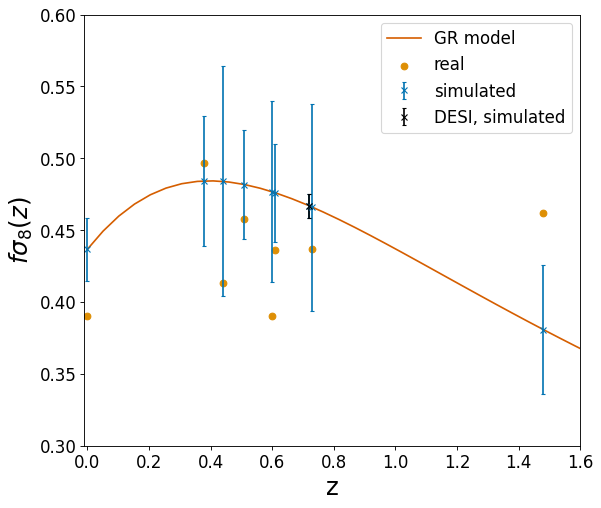

In [11]:
## Plot to check fsigma8 data
plt.figure(figsize=(8, 7), dpi=80)

P_delta2D_GR_lin_universe = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)
fsigma_8_realdata = np.array([0.497 , 0.458 , 0.436, 0.462 , 0.413 , 0.39 , 0.437 , 0.39])
fsigma_8_fracerror = np.array([0.045/0.497 , 0.038/0.458 , 0.034/0.436, 0.045/0.462 , \
                                   0.08/0.413 , 0.063/0.39 , 0.072/0.437 , 0.022/0.39])

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_musigma(P_delta2D_GR_lin_universe, cosmo_universe, MGParam_universe, 1/(np.linspace(0.0, 2.5, 50)+1)), label=r"GR model", color=col[3])
#plt.errorbar(Data_fsigma8[0][:-1]+0.01, fsigma_8_realdata, yerr=fsigma_8_realdata*fsigma_8_fracerror, fmt= 'none', color=col[1])
plt.scatter(Data_fsigma8[0][:-1], fsigma_8_realdata, marker="o", color=col[1], label = "real")
plt.errorbar(Data_fsigma8[0], Data_fsigma8[1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2]))), fmt="x", color=col[0],capsize=2.0, label = "simulated")
plt.errorbar(Data_fsigma8[0][-1], Data_fsigma8[1][-1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2])))[-1], fmt="x", color='k',capsize=2.0, label = "DESI, simulated")

plt.xlabel("z", fontsize=22)
plt.ylabel(r"$f \sigma_8(z)$", fontsize=22)
plt.xlim(-0.01,1.6)
plt.ylim(0.3,0.6)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(fontsize=15)

#plt.savefig("/home/c2042999/PCA_project/Figures/Paper_figures/fsigma8_data.pdf", bbox_inches='tight')


In [12]:
# Using data described in Section 3.4 of https://arxiv.org/pdf/2201.07025 (Jaime's paper)
# Dataset 1 (x3): RSD BOSS DR12 data https://arxiv.org/pdf/1607.03155
# Dataset 2 (x1): BOSS DR16 quasar sample 𝑓𝜎8(𝑧eff) measurement https://arxiv.org/pdf/2007.08998
# Dataset 3 (x3): WiggleZ Dark Energy Survey data https://arxiv.org/pdf/1204.3674
# Dataset 4 (x1): 𝑓𝜎8(𝑧 = 0) from peculiar velocities of Democratic Samples of Supernovae https://arxiv.org/pdf/2105.05185

zeff= 0.72
nbar = 5*10**(-4)
Vol = 3*10**9
Pk2Dobj_lin = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)
f_fe, f_fid = f_frac_err(Pk2Dobj_lin,cosmo_universe,[0,0,0,0,0],2.03, zeff, nbar, Vol)

z_eff = np.array([0.38 , 0.51 , 0.61 , 1.48 , 0.44 , 0.6 , 0.73 , 0.0, zeff])

fsigma_8_realdata = np.array([0.497 , 0.458 , 0.436, 0.462 , 0.413 , 0.39 , 0.437 , 0.39])

fsigma_8_fracerror = np.array([0.045/0.497 , 0.038/0.458 , 0.034/0.436, 0.045/0.462 , \
                               0.08/0.413 , 0.063/0.39 , 0.072/0.437 , 0.022/0.39, f_fe])

reducedcov_fsigma_8 = np.array([[1 , 0.4773 , 0.1704 , 0 , 0 , 0 , 0 , 0,0],
                               [ 0.4773 , 1 , 0.5103 , 0 , 0 , 0 , 0 , 0,0],
                               [0.1704 , 0.5103 , 1 , 0 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 0 , 1 , 0.50992 , 0.0 , 0,0],
                               [0 , 0 , 0 , 0 , 0.50992 , 1 , 0.559965 , 0,0],
                               [0 , 0 , 0 , 0 , 0.0 , 0.559965 , 1 , 0,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0,1]]
                       )


headers = z_eff.tolist()

## Create our data:

fsigma_8_data = np.append(fsigma_8_realdata,[fsigma8_musigma(Pk2Dobj_lin,cosmo_universe, [0,0,0,0,0], [1./(1. + zeff),1./(1. + zeff)])[0]])#fsigma8_ESS_C(cosmo_universe, MGParam_universe, 1/(z_eff+1))

cov_fsigma8 = reducedcov_fsigma_8 * np.outer(fsigma_8_data*fsigma_8_fracerror, fsigma_8_data*fsigma_8_fracerror)
invcov_fsigma8 = np.linalg.inv(cov_fsigma8)

print(tabulate(reducedcov_fsigma_8 * np.outer(fsigma_8_data*fsigma_8_fracerror, fsigma_8_data*fsigma_8_fracerror), headers))

cov_fsigma_8 = reducedcov_fsigma_8 * np.outer(fsigma_8_data*fsigma_8_fracerror, fsigma_8_data*fsigma_8_fracerror)

       0.38         0.51         0.61      1.48     0.44       0.6      0.73       0.0         0.72
-----------  -----------  -----------  --------  -------  --------  --------  --------  -----------
0.002025     0.000816183  0.000260712  0         0        0         0         0         0
0.000816183  0.001444     0.000659308  0         0        0         0         0         0
0.000260712  0.000659308  0.001156     0         0        0         0         0         0
0            0            0            0.002025  0        0         0         0         0
0            0            0            0         0.0064   0.00257   0         0         0
0            0            0            0         0.00257  0.003969  0.00254   0         0
0            0            0            0         0        0.00254   0.005184  0         0
0            0            0            0         0        0         0         0.000484  0
0            0            0            0         0        0         0         0 

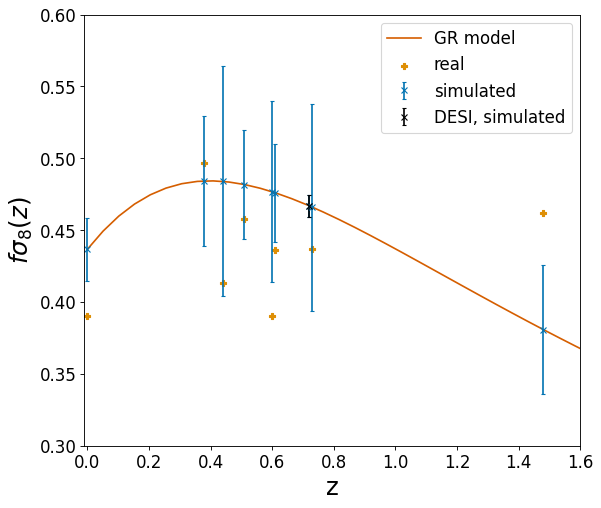

In [13]:
## Plot to check fsigma8 data
plt.figure(figsize=(8, 7), dpi=80)

P_delta2D_GR_lin_universe = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)
fsigma_8_realdata = np.array([0.497 , 0.458 , 0.436, 0.462 , 0.413 , 0.39 , 0.437 , 0.39])

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_musigma(P_delta2D_GR_lin_universe, cosmo_universe, MGParam_universe, 1/(np.linspace(0.0, 2.5, 50)+1)), label=r"GR model", color=col[3])
#plt.errorbar(Data_fsigma8[0][:-1]+0.01, fsigma_8_realdata, yerr=np.sqrt(np.diag(cov_fsigma_8))[:-1], fmt= 'none', color=col[1])
plt.scatter(Data_fsigma8[0][:-1], fsigma_8_realdata, marker="P", color=col[1], label = "real")
plt.errorbar(Data_fsigma8[0], Data_fsigma8[1], yerr=np.sqrt(np.diag(cov_fsigma_8)), fmt="x", color=col[0],capsize=2.0, label = "simulated")
plt.errorbar(Data_fsigma8[0][-1], Data_fsigma8[1][-1], yerr=np.sqrt(np.diag(cov_fsigma_8))[-1], fmt="x", color='k',capsize=2.0, label = "DESI, simulated")

plt.xlabel("z", fontsize=22)
plt.ylabel(r"$f \sigma_8(z)$", fontsize=22)
plt.xlim(-0.01,1.6)
plt.ylim(0.3,0.6)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(fontsize=15)

#plt.savefig("/home/c2042999/PCA_project/Figures/Paper_figures/fsigma8_data.pdf", bbox_inches='tight')


87


/home/c2042999/PCA_project/Parameter_inference_GR/LikelihoodFuncts_PCADR_muSigma.py:1486: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


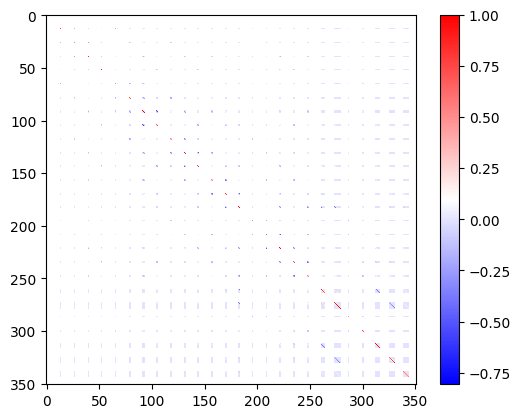

In [14]:
## Plot correlation matrix (scale cuts)

plt.imshow(cov2corr(gauss_invcov_rotated), origin='upper',  cmap='bwr')

print(np.sum(np.any(gauss_invcov_rotated != 0, axis=1)))
plt.colorbar()
plt.show()

(351, 351)
254


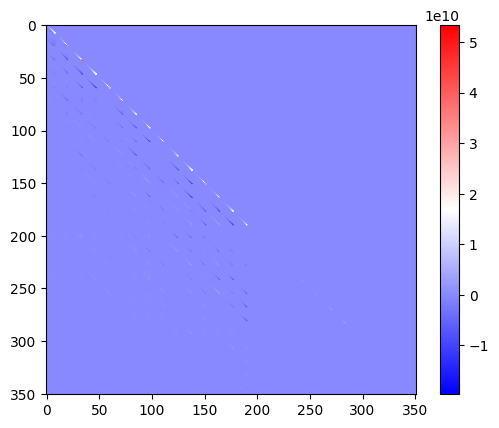

In [15]:
## Plot to choleski matrix (scale cuts)

print(L_choleski_inv.shape)
plt.imshow((L_choleski_inv), origin='upper',  cmap='bwr')
print(np.sum(np.any(L_choleski_inv != 0, axis=1)))

plt.colorbar()
plt.show()

(351, 351)


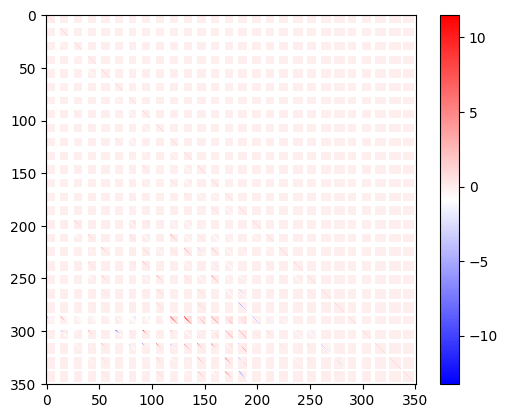

In [16]:
print(L_choleski_inv.shape)
plt.imshow(cov2corr(L_choleski_inv), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()